In [1]:
%matplotlib inline
import numpy as np
import itertools
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
sys.version_info

sys.version_info(major=3, minor=6, micro=4, releaselevel='final', serial=0)

In [4]:
from MomentMatching.newMomentMatch import UnscentedTransform, TaylorTransform, MonteCarloTransform
from MomentMatching.TimeSeriesModel import TimeSeriesModel, UniformNonlinearGrowthModel
from MomentMatching.StateModels import GaussianState
from ExpectationPropagation import EPNodes
from MomentMatching.ExpectationPropagation import TopEP
from Filters.KalmanFilter import KalmanFilterSmoother, PowerKalmanFilterSmoother
from Utils.Metrics import nll, rmse
from Utils.Plot_Helper import plot_gaussian, plot_gaussian_node
from Systems import BearingsOnlyTracking
import logging

In [5]:
SEED = 200

np.random.seed(seed=SEED)

N = 10
system = UniformNonlinearGrowthModel()
# system = BearingsOnlyTracking()
data = system.simulate(N)
x_true, x_noisy, y_true, y_noisy = zip(*data)


power = 1
damping = 1

transform = UnscentedTransform(n=1,  beta=0,  alpha=1, kappa=2)
meas_transform = UnscentedTransform(n=1, beta=0,  alpha=1, kappa=2)

In [31]:
def _power_sweep(power, damping):
#     transform = UnscentedTransform(n=1, beta=0, alpha=1, kappa=2)
    meas_transform = UnscentedTransform(n=1, beta=0, alpha=1, kappa=2)
    transform = TaylorTransform()
#     transform = MonteCarloTransform(number_of_samples=2000)
#     meas_transform = MonteCarloTransform(number_of_samples=2000)
    Nodes = EPNodes(dimension_of_state=1, N=N)
    EP = TopEP(system_model=system,
               moment_matching=transform,
               meas_transform=meas_transform,
               power=power,
               damping=damping)

    EPNodesList = EP.forward_backward_iteration(20, Nodes, y_noisy, list(range(0, N)), x_true)

    Node = [node.marginal for node in EPNodesList[-1]]
    return nll(Node, x_true), rmse(Node, x_true)

In [40]:
x = 5
y = 5
power_range = np.linspace(0.3, 1.0, num=x)
damp_range = np.linspace(0.3, 1.0, num=y)

In [41]:
results = []
NLL = []
RMSE = []
for power, damping in itertools.product(power_range, damp_range):
    ans = _power_sweep(power, damping)
    a1, a2 = ans
    NLL.append(a1)
    RMSE.append(a2)
    results.append(ans)

/Users/Pontragyin/Documents/GitHub/pyStateEstimator/StateModel/GaussianState.py:229: RuntimeWarning: invalid value encountered in log
  logdet = np.log(2 * np.pi) + np.log(np.linalg.det(self.cov))
/Users/Pontragyin/Documents/GitHub/pyStateEstimator/StateModel/GaussianState.py:205: RuntimeWarning: divide by zero encountered in true_divide
  cov = self.cov / power


In [42]:
results

[(19.202281052075627, 12.690642811073408),
 (96.26893686237189, 14.979560015221338),
 (nan, 52.585702903547926),
 (nan, 49.214397438273004),
 (1.7471723435907247, 1.2940710081294144),
 (68.35988489591799, 13.197781813680693),
 (79.44163490353954, 13.324403063689386),
 (44.86597106702272, 9.878141322519863),
 (29.177739830601883, 7.305767548059076),
 (1.886073035518311, 7.35871666968798),
 (41.641688829183664, 24.018710635591233),
 (102.39460295222423, 13.51457555218402),
 (106.42516253697943, 13.555647968746182),
 (nan, 88.08023208707685),
 (41.61352658204006, 7.479060413326054),
 (77.85809979731017, 10.046447003410274),
 (1.4166654665270453, 1.1253301145415253),
 (65.85501237162602, 20.52680364500851),
 (80.60935512468401, 10.07600030522132),
 (298.31092786185263, 8.000128218603038),
 (109.73018489420217, 10.509057833607951),
 (96.54148650849325, 11.70219261362294),
 (777.1097281461592, 13.915067538661356),
 (840.4830231445583, 7.995707736108045),
 (262.03943072413915, 13.932947295199

In [43]:
len(results)

25

In [44]:
ll = np.array(NLL)
Rmse = np.array(RMSE)

In [45]:

img_ll = ll.reshape(x, y)
img_rmse = Rmse.reshape(x, y)

In [46]:
methods = [None, 'none', 'nearest', 'bilinear', 'bicubic', 'spline16',
           'spline36', 'hanning', 'hamming', 'hermite', 'kaiser', 'quadric',
           'catrom', 'gaussian', 'bessel', 'mitchell', 'sinc', 'lanczos']

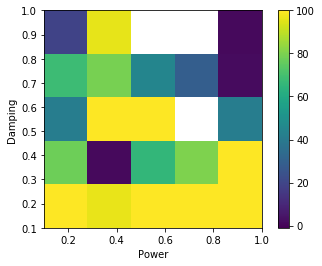

In [47]:
plt.imshow(img_ll, interpolation=methods[0], extent=[0.1,1,0.1,1], cmap='viridis', clim=(-1, 100))
ax = plt.gca()
ax.set_xlabel('Power')
ax.set_ylabel('Damping')
ax.grid(False)
plt.colorbar()

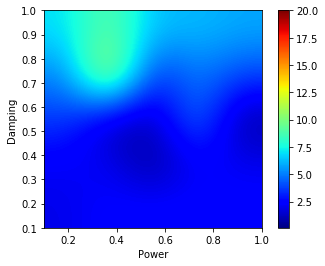

In [30]:
plt.imshow(np.log(img_rmse), interpolation=methods[4], extent=[0.1,1,0.1,1], cmap='jet', vmax=20, vmin=0.1)
ax = plt.gca()
ax.set_xlabel('Power')
ax.set_ylabel('Damping')
ax.grid(False)
plt.colorbar()

In [27]:
np.log(np.max(img_rmse))

12.069904821262728

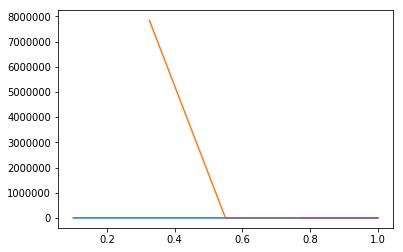

In [17]:
for i in range(len(power_range)):
    plt.plot(power_range, img_ll[:, i])

In [28]:
Rmse

array([1.0766e+03, 1.2310e+04, 5.5433e+02, 5.2717e+02, 3.5970e+02,
       1.6553e+02, 1.7454e+05, 2.2510e+01, 1.5534e+02, 5.0394e+01,
       4.2556e+01, 3.4087e+00, 2.8434e+00, 1.6574e+02, 1.9700e+00,
       9.4423e+00, 8.2526e+00, 1.7383e+00, 1.0331e+01, 8.0622e+00,
       7.1930e+00, 1.2635e+01, 1.3320e+01, 1.2973e+01, 1.2586e+01])